In [9]:
# Import required libraries
import happybase
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
# Configuration
HBASE_HOST = 'localhost'  # Change to 'hbase' if running inside Docker
HBASE_PORT = 9090
TABLE_NAME = 'ad_decisions'

print(f"Connecting to HBase at {HBASE_HOST}:{HBASE_PORT}...")

Connecting to HBase at localhost:9090...


## Load Data from HBase

In [11]:
def load_decisions_from_hbase(hours=24):
    """
    Load ad decisions from HBase for the last N hours.
    """
    try:
        connection = happybase.Connection(HBASE_HOST, port=HBASE_PORT)
        table = connection.table(TABLE_NAME)
        
        # Calculate time range
        now = datetime.now()
        start_time = now - timedelta(hours=hours)
        start_key = start_time.strftime("%Y%m%d_%H%M%S")
        end_key = now.strftime("%Y%m%d_%H%M%S")
        
        print(f"Scanning HBase from {start_key} to {end_key}...")
        
        rows = []
        scanner = table.scan(row_start=start_key.encode(), row_stop=end_key.encode())
        
        for key, data in scanner:
            decision_id = key.decode('utf-8')
            
            # Helper to safely decode
            def get_val(col_name, default=''):
                val = data.get(col_name, default.encode() if isinstance(default, str) else default)
                return val.decode('utf-8') if isinstance(val, bytes) else val
            
            row_dict = {
                'decision_id': decision_id,
                'traffic_score': float(get_val(b'metrics:traffic_score', '0.0')),
                'weather_score': float(get_val(b'metrics:weather_score', '0.0')),
                'sentiment_score': float(get_val(b'metrics:sentiment_score', '0.0')),
                'global_score': float(get_val(b'metrics:global_score', '0.0')),
                'decision': get_val(b'decision:result', 'NO_AD'),
                'target_locations': get_val(b'target:locations', '[]'),
                'decision_time': get_val(b'timestamps:decision_time', ''),
            }
            rows.append(row_dict)
        
        connection.close()
        print(f"Loaded {len(rows)} decisions")
        return rows
    
    except Exception as e:
        print(f"Error connecting to HBase: {e}")
        print("Generating sample data for demonstration...")
        return generate_sample_data()

def generate_sample_data(n=100):
    """Generate sample data if HBase is not available"""
    import numpy as np
    np.random.seed(42)
    
    data = []
    for i in range(n):
        traffic = np.random.random()
        weather = np.random.random()
        sentiment = np.random.random()
        global_score = 0.5 * traffic + 0.3 * weather + 0.2 * sentiment
        
        data.append({
            'decision_id': f'{datetime.now().strftime("%Y%m%d_%H%M")}{i:04d}',
            'traffic_score': traffic,
            'weather_score': weather,
            'sentiment_score': sentiment,
            'global_score': global_score,
            'decision': 'SHOW_AD' if global_score > 0.6 else 'NO_AD',
            'target_locations': '[]',
            'decision_time': datetime.now().isoformat(),
        })
    return data

# Load data
data = load_decisions_from_hbase(hours=24)
df = pd.DataFrame(data)

# Display first few rows
print("\nFirst few records:")
df.head()

Scanning HBase from 20260105_121059 to 20260106_121059...
Loaded 10 decisions

First few records:


,decision_id,traffic_score,weather_score,sentiment_score,global_score,decision,target_locations,decision_time
0,20260106_120058,0.172678,0.6,0.000000,0.309071,NO_AD,[],2026-01-06 12:00:58
1,20260106_120158,0.220261,0.6,0.105263,0.349157,NO_AD,[],2026-01-06 12:01:58
2,20260106_120258,0.219325,0.6,0.105263,0.348783,NO_AD,[],2026-01-06 12:02:58
3,20260106_120358,0.239080,0.6,0.105263,0.356685,NO_AD,[],2026-01-06 12:03:58
4,20260106_120458,0.250575,0.6,0.157895,0.371809,NO_AD,[],2026-01-06 12:04:58


In [12]:
# Data overview
print("Dataset Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)
print("\nBasic Statistics:")
df[['traffic_score', 'weather_score', 'sentiment_score', 'global_score']].describe()

Dataset Shape: (10, 8)

Column Types:
decision_id          object
traffic_score       float64
weather_score       float64
sentiment_score     float64
global_score        float64
decision             object
target_locations     object
decision_time        object
dtype: object

Basic Statistics:


,traffic_score,weather_score,sentiment_score,global_score
count,10.000000,1.000000e+01,10.000000,10.000000
mean,0.274636,6.000000e-01,0.126316,0.375118
std,0.067268,1.170278e-16,0.050847,0.035348
min,0.172678,6.000000e-01,0.000000,0.309071
25%,0.224966,6.000000e-01,0.105263,0.351039
50%,0.260153,6.000000e-01,0.157895,0.375640
75%,0.325670,6.000000e-01,0.157895,0.401847
max,0.384674,6.000000e-01,0.157895,0.425449


## Decision Distribution

Decision Distribution:
decision
NO_AD    10
Name: count, dtype: int64

Ad Show Rate: 0.00%


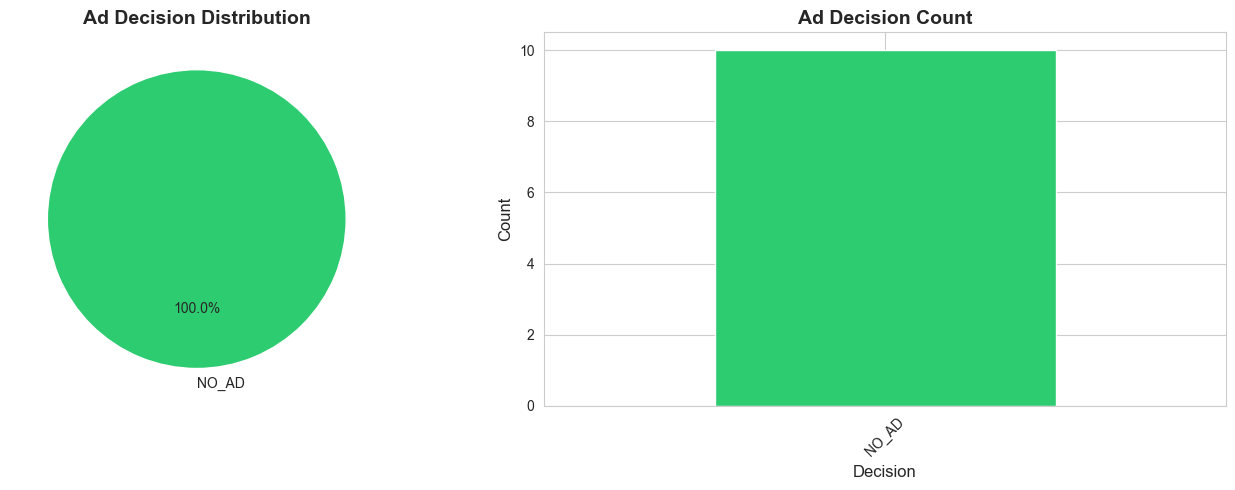

In [13]:
# Count decisions
decision_counts = df['decision'].value_counts()
print("Decision Distribution:")
print(decision_counts)
print(f"\nAd Show Rate: {(decision_counts.get('SHOW_AD', 0) / len(df) * 100):.2f}%")

# Plot decision distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
decision_counts.plot(kind='pie', ax=ax1, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Ad Decision Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('')

# Bar chart
decision_counts.plot(kind='bar', ax=ax2, color=colors)
ax2.set_title('Ad Decision Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Decision', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Score Distributions

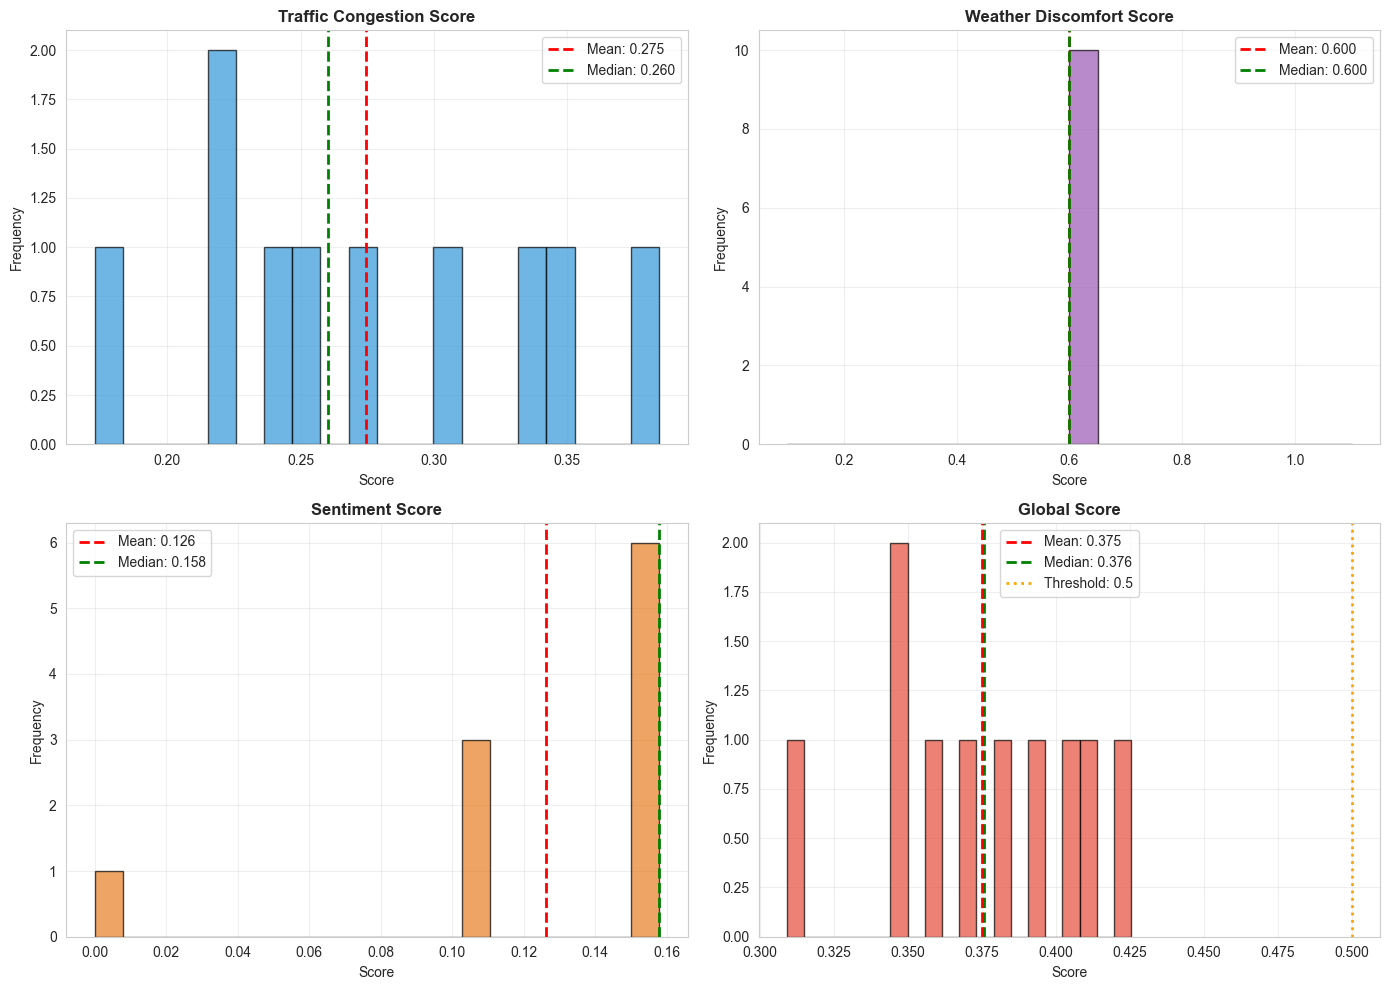

In [15]:
# Plot score distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scores = ['traffic_score', 'weather_score', 'sentiment_score', 'global_score']
titles = ['Traffic Congestion Score', 'Weather Discomfort Score', 'Sentiment Score', 'Global Score']
colors_list = ['#3498db', '#9b59b6', '#e67e22', '#e74c3c']

for idx, (score, title, color) in enumerate(zip(scores, titles, colors_list)):
    ax = axes[idx // 2, idx % 2]
    
    # Histogram
    df[score].hist(bins=20, ax=ax, color=color, alpha=0.7, edgecolor='black')
    ax.axvline(df[score].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df[score].mean():.3f}')
    ax.axvline(df[score].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df[score].median():.3f}')
    
    if score == 'global_score':
        ax.axvline(0.5, color='orange', linestyle=':', linewidth=2, label='Threshold: 0.5')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Score', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Score Comparison by Decision Type

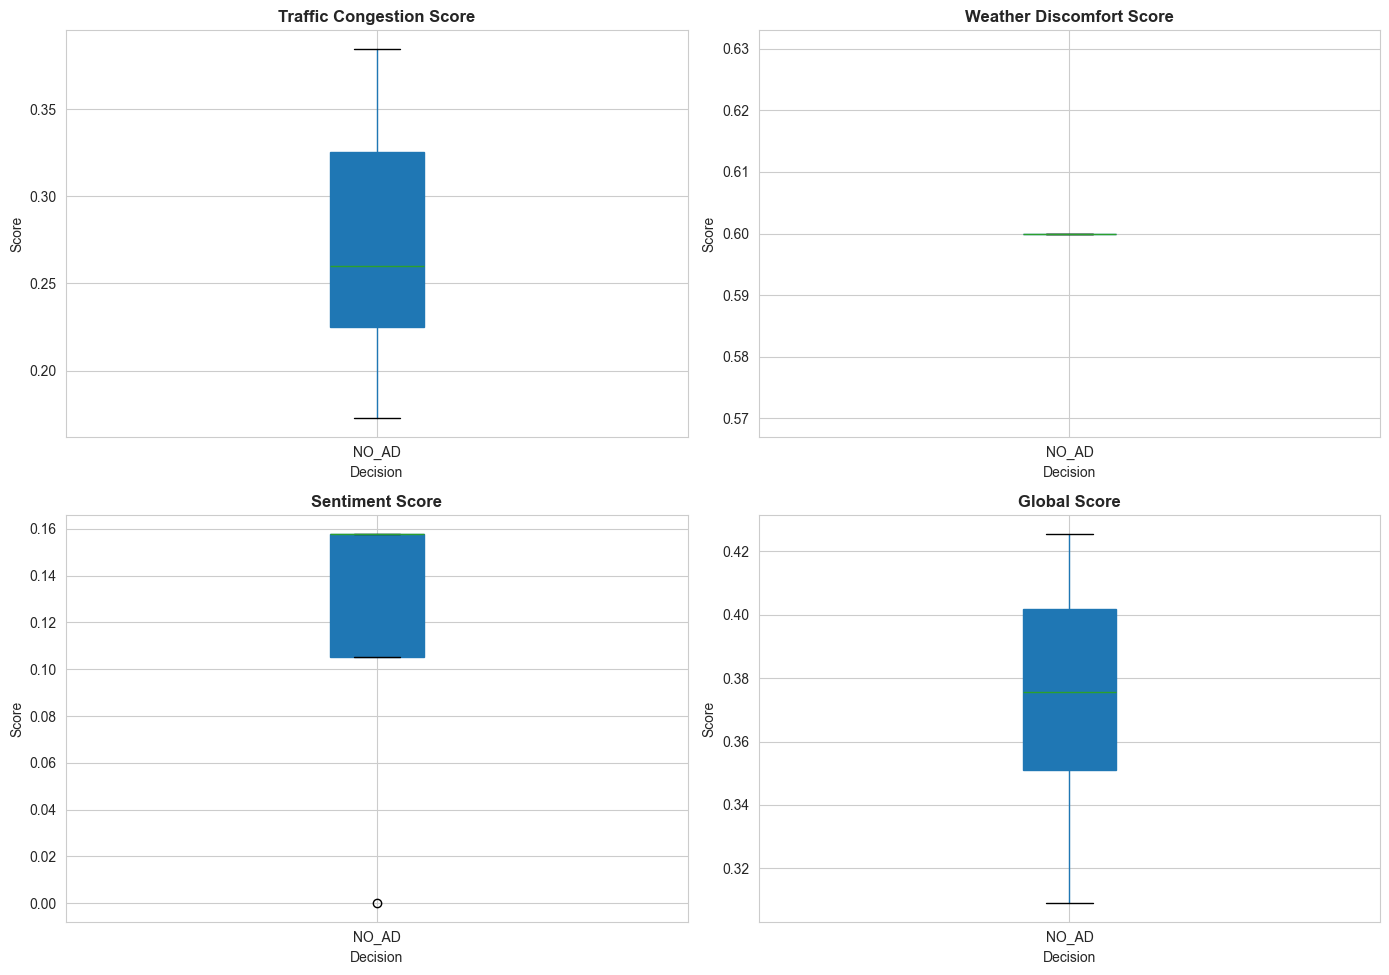

In [16]:
# Box plots comparing scores between SHOW_AD and NO_AD decisions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (score, title, color) in enumerate(zip(scores, titles, colors_list)):
    ax = axes[idx // 2, idx % 2]
    
    df.boxplot(column=score, by='decision', ax=ax, patch_artist=True)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Decision', fontsize=10)
    ax.set_ylabel('Score', fontsize=10)
    ax.get_figure().suptitle('')  # Remove default title
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Score Correlations

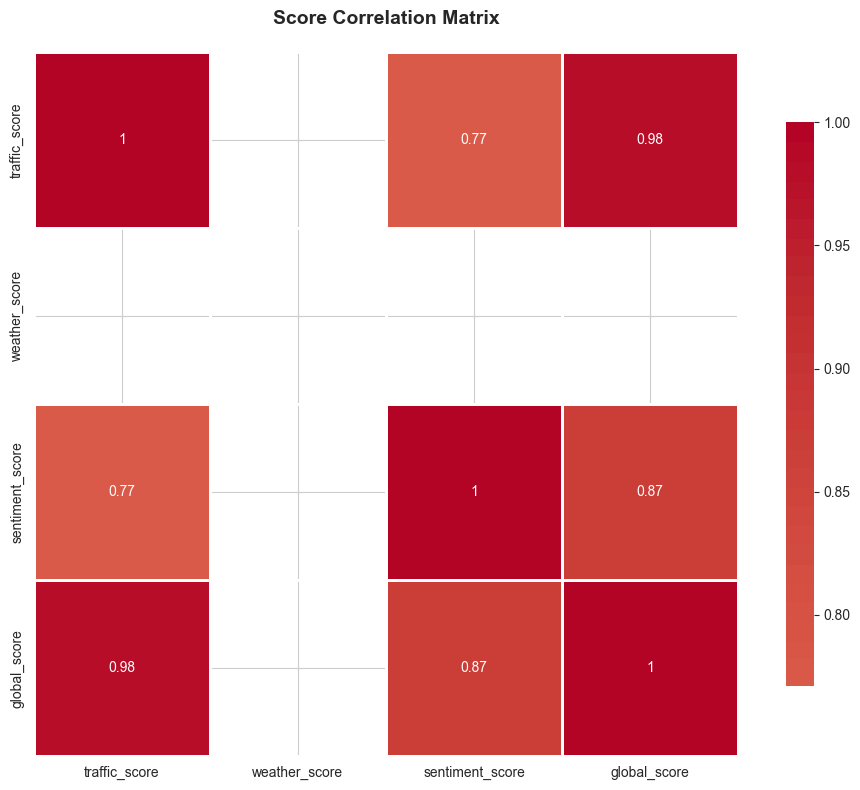


Correlation with Global Score:
global_score       1.000000
traffic_score      0.983093
sentiment_score    0.874797
weather_score           NaN
Name: global_score, dtype: float64


In [17]:
# Correlation matrix
correlation_matrix = df[scores].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Score Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation with Global Score:")
print(correlation_matrix['global_score'].sort_values(ascending=False))

## Scatter Plot Matrix

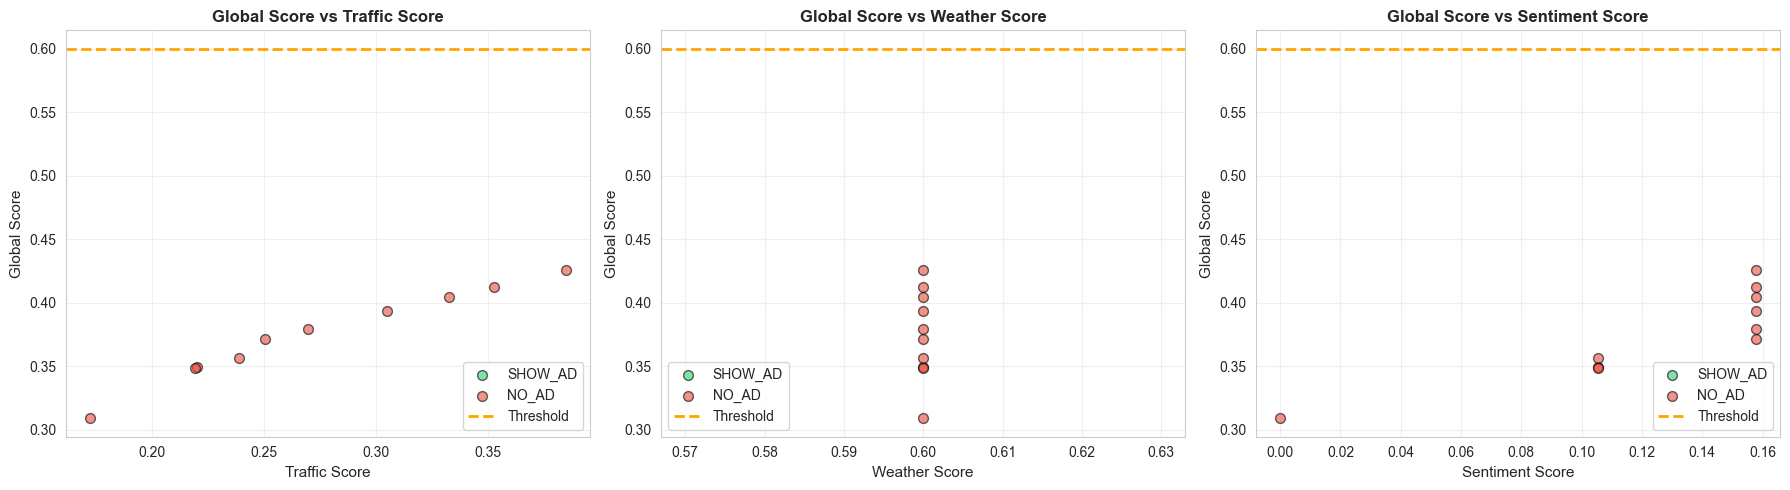

In [18]:
# Create scatter plot showing relationship between scores and decision
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

component_scores = ['traffic_score', 'weather_score', 'sentiment_score']
for idx, score_name in enumerate(component_scores):
    ax = axes[idx]
    
    # Color by decision
    show_ad = df[df['decision'] == 'SHOW_AD']
    no_ad = df[df['decision'] == 'NO_AD']
    
    ax.scatter(show_ad[score_name], show_ad['global_score'], 
               alpha=0.6, c='#2ecc71', label='SHOW_AD', s=50, edgecolors='black')
    ax.scatter(no_ad[score_name], no_ad['global_score'], 
               alpha=0.6, c='#e74c3c', label='NO_AD', s=50, edgecolors='black')
    
    ax.axhline(0.6, color='orange', linestyle='--', linewidth=2, label='Threshold')
    ax.set_xlabel(score_name.replace('_', ' ').title(), fontsize=11)
    ax.set_ylabel('Global Score', fontsize=11)
    ax.set_title(f'Global Score vs {score_name.replace("_", " ").title()}', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary Statistics

In [19]:
# Summary statistics by decision type
print("=" * 80)
print("SUMMARY STATISTICS BY DECISION TYPE")
print("=" * 80)

for decision_type in df['decision'].unique():
    print(f"\n{decision_type}:")
    print("-" * 40)
    subset = df[df['decision'] == decision_type]
    print(f"Count: {len(subset)}")
    print(f"Percentage: {len(subset) / len(df) * 100:.2f}%")
    print("\nScore Averages:")
    for score in scores:
        print(f"  {score:20s}: {subset[score].mean():.4f} (±{subset[score].std():.4f})")

SUMMARY STATISTICS BY DECISION TYPE

NO_AD:
----------------------------------------
Count: 10
Percentage: 100.00%

Score Averages:
  traffic_score       : 0.2746 (±0.0673)
  weather_score       : 0.6000 (±0.0000)
  sentiment_score     : 0.1263 (±0.0508)
  global_score        : 0.3751 (±0.0353)


## Export Results

In [11]:
# Optional: Export to CSV
output_file = '../analyse/ad_decisions_export.csv'
df.to_csv(output_file, index=False)
print(f"Data exported to {output_file}")
print(f"Total records: {len(df)}")

Data exported to ../analyse/ad_decisions_export.csv
Total records: 4
